In [5]:
import re
from konlpy.tag import Kkma
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')


# 데이터 csv로 변경

In [6]:
def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()
    return msg_list

def apply_kko_regex(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = dt.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제-> 안하고 싶은데여..
                """
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                """
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)
                

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "Speaker", "timetype", "time", "contents"])
    kko_parse_result.to_csv("kko_regex.csv", index=False)

    return kko_parse_result

if __name__ == '__main__':
    msg_list = read_kko_msg("기프1조.txt")
    apply_kko_regex(msg_list)
    
    
df = pd.read_csv("kko_regex.csv")
df.head()

,Date,Speaker,timetype,time,contents
0,2021-03-20,정선용,오후,4:08,1조 톡방입니다~~!!
1,2021-03-20,금나연,오후,4:08,안녕하세요~~
2,2021-03-20,전희선,오후,4:08,와~!
3,2021-03-20,이승희,오후,4:13,기프OT 노션 사이트입니다. https://han.gl/SrPM1
4,2021-03-20,금나연,오후,4:23,https://docs.google.com/document/d/1NhCtPL0LtF...


# 데이터 날짜 가공

In [7]:
df[df['contents'].isnull()]# 대부분 이모티콘

,Date,Speaker,timetype,time,contents


In [8]:
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      530 non-null    object
 1   Speaker   530 non-null    object
 2   timetype  530 non-null    object
 3   time      530 non-null    object
 4   contents  530 non-null    object
dtypes: object(5)
memory usage: 20.8+ KB


In [10]:
#datetime으로 변경
df['Date'] = pd.to_datetime(df['Date'])
# 년,월,일로 변경
df["year"] = df['Date'].dt.strftime('%Y')
df["month"] = df['Date'].dt.strftime('%m')
df["day"] = df['Date'].dt.strftime('%d')

df['24time'] = df['timetype'] + ' ' + df['time']
df['24time'] = df['24time'].map(lambda x : x.replace('오전','AM'))
df['24time'] = df['24time'].map(lambda x : x.replace('오후','PM'))
#24시간으로 datetime형 변경
temp = []
transform_time = []
for i in range(len(df)):
    time = df['24time'][i]
    temp.append(dt.datetime.strptime(time, '%p %I:%M'))
    transform_time.append(temp[i].time())

df['24time'] = transform_time

# 문자의 길이 반환

title_len=[]
    
for i in range(len(df)):
    ttl = len(df['contents'][i])
    title_len.append(ttl)

df['length'] = title_len

# 시간을 추출

hours_list=[]

for i in range(len(df)):
    hours = df['24time'][i].hour
    hours_list.append(hours)
    
df['hour'] = hours_list

# 분을 추출

minutes_list=[]

for i in range(len(df)):
    minutes = df['24time'][i].minute
    minutes_list.append(minutes)
df['minutes'] = minutes_list

#time column drop
df=df.drop(['time'],axis=1)

df.head()



    
    


,Date,Speaker,timetype,contents,year,month,day,24time,length,hour,minutes
0,2021-03-20,정선용,오후,1조 톡방입니다~~!!,2021,03,20,16:08:00,12,16,8
1,2021-03-20,금나연,오후,안녕하세요~~,2021,03,20,16:08:00,7,16,8
2,2021-03-20,전희선,오후,와~!,2021,03,20,16:08:00,3,16,8
3,2021-03-20,이승희,오후,기프OT 노션 사이트입니다. https://han.gl/SrPM1,2021,03,20,16:13:00,36,16,13
4,2021-03-20,금나연,오후,https://docs.google.com/document/d/1NhCtPL0LtF...,2021,03,20,16:23:00,96,16,23


In [11]:
df['Speaker'].astype('category')

0      정선용
1      금나연
2      전희선
3      이승희
4      금나연
      ... 
525    금나연
526    금나연
527    금나연
528    금나연
529    금나연
Name: Speaker, Length: 530, dtype: category
Categories (6, object): ['금나연', '남기쁨', '민지', '이승희', '전희선', '정선용']

In [12]:
df['Speaker'].value_counts()

금나연    192
남기쁨    121
이승희     80
정선용     65
전희선     53
민지      19
Name: Speaker, dtype: int64

## 피쳐 정리

In [13]:
def preprocessing(df):
    name_list=df['Speaker'].unique()
    #기본 데이터 프레임 생성(이름, 빈도)
    feature=pd.DataFrame(df['Speaker'].value_counts())
    feature.rename({'Speaker':'frequency'}, inplace=True)

    #전체 글자 수-> 시간이 좀 오래 걸림시간이 좀 오래 걸림
    feature.loc[:,['length','notice','vote','file','link','image','video','imoticon','group_call','?','!','happiness', 'sadness']]=0
    for i in range(len(df)):
        for name in name_list:
            if (df.loc[i,['Speaker']].item()==name):
                feature.loc[[name],['length']]+=len(df.loc[i,['contents']].item())  
                #톡게시판, 파일, 링크 파싱
                if "톡게시판 '공지': " in df.loc[i,['contents']].item():
                    feature.loc[[name],['notice']]+=1
                if "톡게시판 '투표':" in df.loc[i,['contents']].item():
                    feature.loc[[name],['vote']]+=1
                if "파일: " in df.loc[i,['contents']].item():
                    feature.loc[[name],['file']]+=1
                if ("http://" in df.loc[i,['contents']].item()) or ("https://" in df.loc[i,['contents']].item()):
                    feature.loc[[name],['link']]+=1
                #사진 한 장
                if df.loc[i,['contents']].item()=="사진":
                    feature.loc[[name],['image']]+=1
                #사진 여러 장(정규 표현식 사용)
                if df.loc[i,['contents']].item() in re.compile("사진\s\d장").findall(df.loc[i,['contents']].item()):
                    feature.loc[[name],['image']]+=1
                if df.loc[i,['contents']].item()=="동영상":
                    feature.loc[[name],['video']]+=1
                if df.loc[i,['contents']].item()=="이모티콘":
                    feature.loc[[name],['imoticon']]+=1
                if df.loc[i,['contents']].item()=="그룹콜 해요":
                    feature.loc[[name],['group_call']]+=1
                #물음표 개수
                count_qmark=df.loc[i,['contents']].item().count('?')
                feature.loc[[name],['?']]+=count_qmark
                #느낌표 개수
                count_emark=df.loc[i,['contents']].item().count('!')
                feature.loc[[name],['?']]+=count_emark
                #기쁨
                count_emark=df.loc[i,['contents']].item().count('ㅋ')
                feature.loc[[name],['happiness']]+=count_emark
                #슬픔
                count_emark1=df.loc[i,['contents']].item().count('ㅜ')
                count_emark2=df.loc[i,['contents']].item().count('ㅠ')
                feature.loc[[name],['sadness']]+=(count_emark1+count_emark2)
                    
                    
    
    return feature

In [14]:
preprocessing(df)

,Speaker,length,notice,vote,file,link,image,video,imoticon,group_call,?,!,happiness,sadness
금나연,192,2741,1,1,1,8,6,1,2,0,54,0,261,6
남기쁨,121,1818,0,0,1,3,3,0,0,0,36,0,103,0
이승희,80,597,0,0,1,1,3,0,1,0,30,0,45,3
정선용,65,1114,0,0,0,2,8,0,0,0,35,0,25,21
전희선,53,709,0,0,0,0,0,0,3,1,29,0,30,1
민지,19,462,0,0,0,0,1,0,0,0,27,0,0,4


In [17]:
#df[df['Speaker']=='남기쁨] [오후 11:14] [한견']

,Date,Speaker,timetype,contents,year,month,day,24time,length,hour,minutes
20259,2020-10-05,남기쁨] [오후 11:14] [한견,오후,‼️새롭게 개편된‼️ 필봉굿패 저잣거리에서 새 집행부와 함께할 2기 회원을 모집합니다!,2020,10,05,23:13:00,48,23,13


In [11]:
#df[df['Speaker']=='남기쁨] [오후 10:22] [남기쁨']

,Date,Speaker,timetype,contents,year,month,day,24time,length,hour,minutes
10392,2019-12-02,남기쁨] [오후 10:22] [남기쁨,오후,(상관없),2019,12,02,21:20:00,5,21,20


C:\Users\sunyong\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\sunyong\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


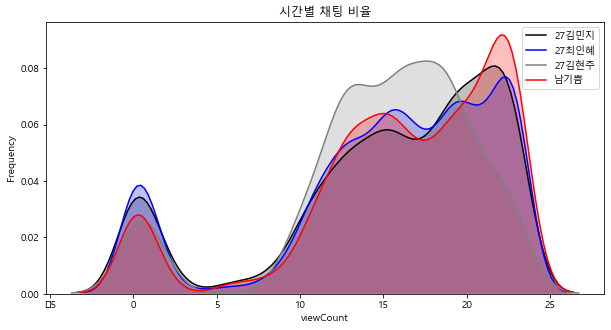

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

g = sns.kdeplot(df['hour'][(df['Speaker'] == '27김민지') & (df["hour"].notnull())], color="Black", shade = True)
g = sns.kdeplot(df['hour'][(df['Speaker'] == '27최인혜') & (df["hour"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(df['hour'][(df['Speaker'] == '27김현주') & (df["hour"].notnull())], ax =g, color="Gray", shade= True)
g = sns.kdeplot(df['hour'][(df['Speaker'] == '남기쁨') & (df["hour"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("viewCount")
g.set_ylabel("Frequency")
plt.title("시간별 채팅 비율")
g = g.legend(["27김민지","27최인혜","27김현주","남기쁨"])


# pie chart 그리기

In [13]:
list(df['Speaker'].unique())

['27김민지',
 '27최인혜',
 '27김현주',
 '남기쁨',
 '남기쁨] [오후 10:22] [남기쁨',
 '남기쁨] [오후 11:14] [한견']

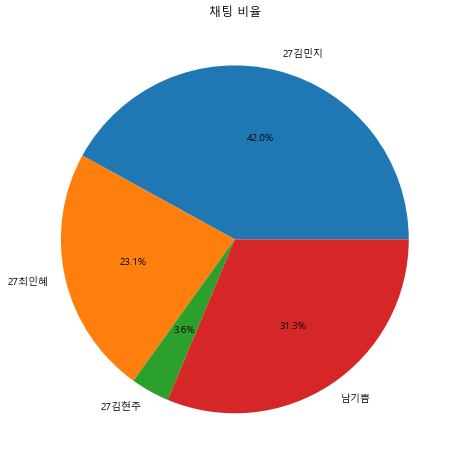

In [14]:
speaker_list = ['27김민지','27최인혜','27김현주','남기쁨']
ratio = []
for i in speaker_list:
    ratio.append(round(len(df[df['Speaker']==i])/len(df)*100,1))
labels = ['27김민지','27최인혜','27김현주','남기쁨']
plt.figure(figsize=(8,8))
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.title('채팅 비율')
plt.show()